# SSDMobilenetv2 Implementation
MobileNet is a class of model that are called for applications in mobile and embedded level devices. Single Shot Detector or SSD is a technique based on a forward convolitional network that generates a collection of fixed size boxes and scores for presence of object class instances in that those boxes.

MobileNetSSD is an object detection model that where the SSD layer uses MobileNet as a backbone to achieve fast object detection on low power devices.

This notebook will show you how to use the MobileNetSSD model to detect objects in an image using OpenVINO™ toolkit.
Steps included here:
1. Downloading and loading the model 
2. Observing results with original model
3. Converting model to IR format 
4. Observing results with IR model

In [1]:
#imports here
import tensorflow as tf 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Markdown
from openvino.inference_engine import IECore
from pathlib import Path
import re

2023-03-16 12:33:56.452846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 12:33:56.452946: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Downloading and loading the model
We will be using tensorflow's get_file method to download the model. The model is documented at the [TensorFlowHub](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1).
The specific model we will be using is the one that is trained on the COCO dataset. The model is trained to detect 90 classes of objects. The model is trained to detect objects in images of size 320x320 and also uses a feature pyramid network to detect objects at different scales.

In [2]:
source = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
model_name = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
model_dir = Path(tf.keras.utils.get_file(model_name, source, untar=True))

Note : Since Tensorflow Object Detection API is not installed to keep in line with the requirement.txt, and the model is an Object Detection object, I am using the serving_default signature to load the model and run inference on that with custom helper functions.

In [3]:
model = tf.saved_model.load(model_dir/'saved_model')
model = model.signatures['serving_default']


2023-03-16 12:34:00.839604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/suhas/openvino_env/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-16 12:34:00.839686: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 12:34:00.839713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Magnus): /proc/driver/nvidia/version does not exist
2023-03-16 12:34:00.839938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Observing results with original model
To keep notebook requirements minimum, we will be using the following helper functions to load the model and run inference on the model, this can also be done with TensorFlow's Object Detection API, but installing and getting that to work is beyond the scope of this notebook.

In [4]:
#Preprocessing function
def preprocess_image(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = tf.convert_to_tensor(image, dtype=tf.uint8)
    image = tf.expand_dims(image, axis=0)
    return image

    

In [5]:
#Inference function
def inference_engine_tf(image,output_tensor,id_to_display_name,confidence_threshold=0.6):
    image = cv2.imread(image)
    image_stock = image.copy()
    image_stock = cv2.cvtColor(image_stock, cv2.COLOR_BGR2RGB)
    boxes = output_tensor['detection_boxes']
    classes = output_tensor['detection_classes']
    scores = output_tensor['detection_scores']
    num_detections = output_tensor['num_detections']
    for i in range(int(num_detections[0])):
        if scores[0][i] > confidence_threshold:
            box = boxes[0][i]
            ymin = int(box[0] * image.shape[0])
            xmin = int(box[1] * image.shape[1])
            ymax = int(box[2] * image.shape[0])
            xmax = int(box[3] * image.shape[1])
            class_id = int(classes[0][i])
            display_name = id_to_display_name.get(class_id,f'Label unknown {class_id}')
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, display_name, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    fig, axs = plt.subplots(1, 2,figsize=(20, 20))

    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1].imshow(image_stock)
    axs[0].set_title('Inference Engine Output')
    axs[1].set_title('Original Image')
    plt.show()



Since the model does not come with label map, we will be getting the label map from mscoco_label_map.pbtxt file.
This file can be found [here](). Also I have used re to decode the label map file and store it in a dictionary instead of protobuf to keep the notebook requirements compatible with current requirements of this repository.

In [6]:
#now to get the class names
# Open the label map file and read its contents
label_path = Path('mscoco_label_map.pbtxt')
with open('mscoco_label_map.pbtxt', 'r') as f:
    label_map_data = f.read()

# Define a regular expression pattern to extract item entries
item_pattern = re.compile(r'item\s*\{(.*?)\}', re.DOTALL)

# Find all item entries in the label map data
items = item_pattern.findall(label_map_data)

# Create a dictionary to map class ids to display names
id_to_display_name = {}

# Iterate over all item entries
for item in items:
    # Extract the id and display_name fields from the item entry
    id_match = re.search(r'id\s*:\s*(\d+)', item)
    display_name_match = re.search(r'display_name\s*:\s*"(.+?)"', item)

    if id_match and display_name_match:
        # Get the id and display_name values
        id_value = int(id_match.group(1))
        display_name_value = display_name_match.group(1)

        # Add an entry to the dictionary mapping the id to the display name
        id_to_display_name[id_value] = display_name_value


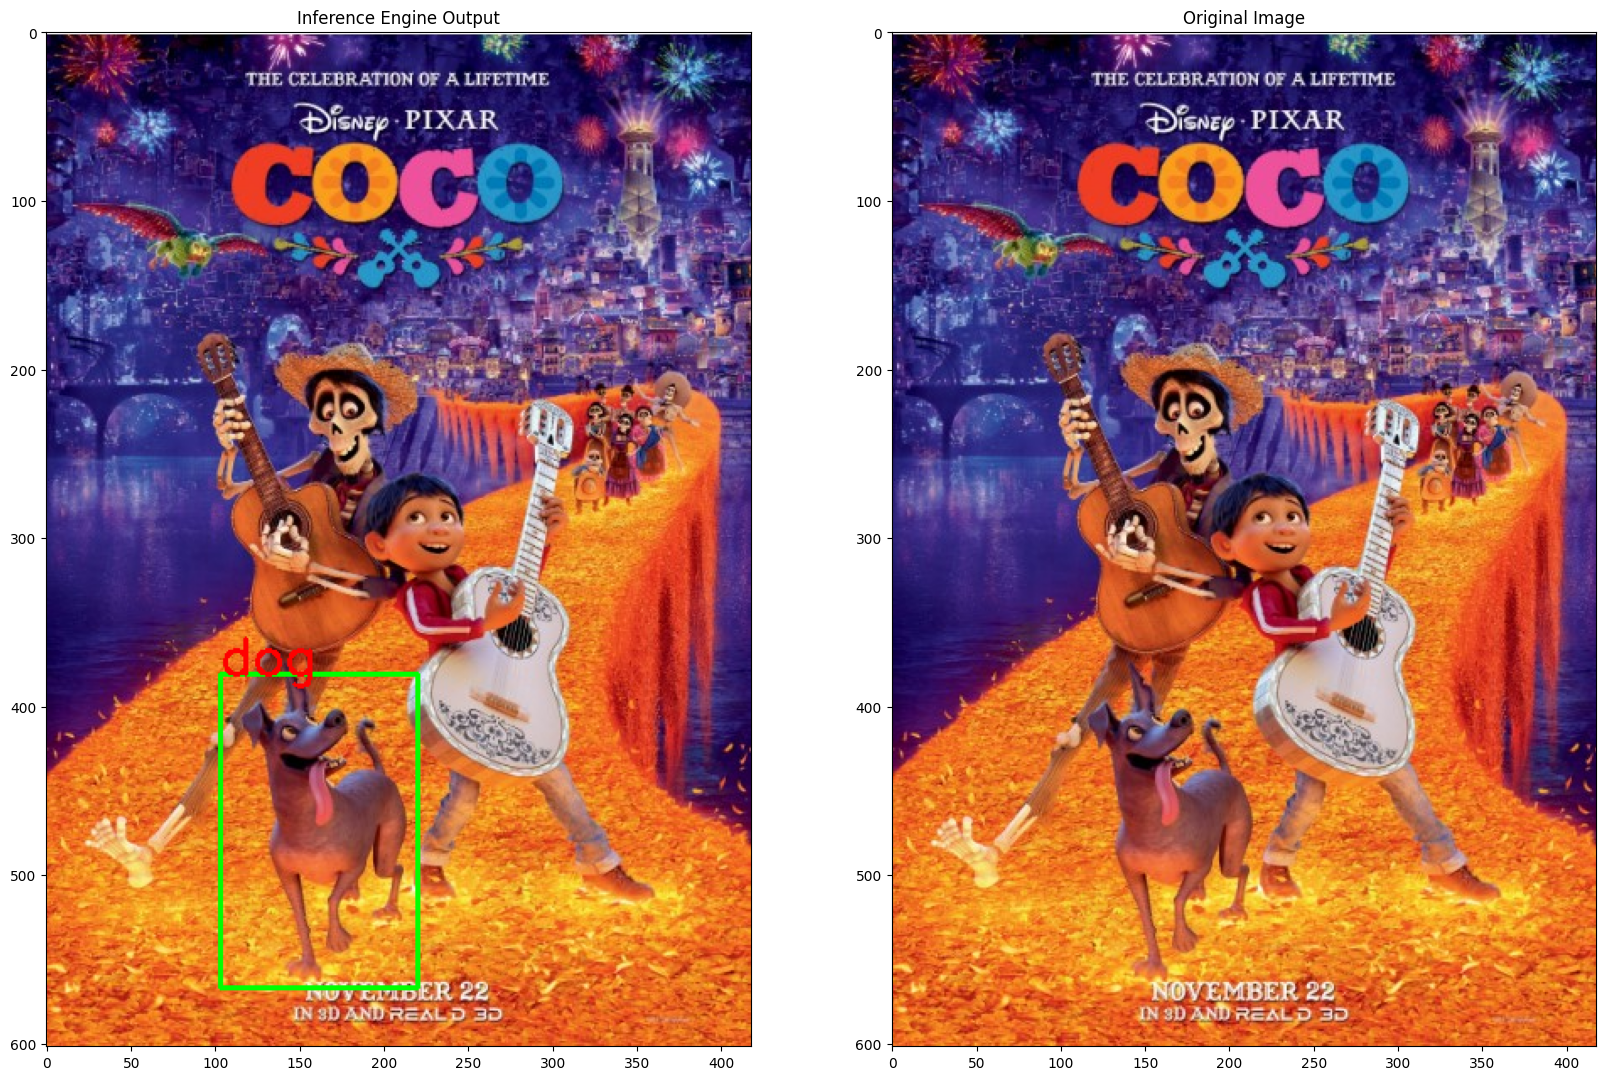

In [7]:
image_path = Path('Screenshot 2023-03-10 190018.jpg')
processed_image = preprocess_image(str(image_path))
output_tensor = model(processed_image)
inference_engine_tf(str(image_path),output_tensor,id_to_display_name)

## 3. Converting model to IR format


In [18]:
output_dir = Path('model')
mo_command = f"""mo
                 --saved_model_dir "{model_dir/'saved_model'}"
                 --input_shape "[1,320,320,3]"
                 --model_name "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
                 --tensorflow_object_detection_api_pipeline_config "{model_dir/'pipeline.config'}"
                 --output_dir "{output_dir/model_name}"
                 --transformations_config "ssd_support_api_v2.0.json"
                 """
mo_command = " ".join(mo_command.split())

In [19]:
!$mo_command

/home/suhas/openvino_env/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: google3.third_party.tensorflow.python.ops.nn_ops is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
/home/suhas/openvino_env/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: google3.third_party.tensorflow_models.object_detection.models.feature_map_generators is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
[ WARNING ]  The pre-processing block has been removed. Only nodes performing mean value subtraction and scaling (if applicable) are kept. It is necessary to resize an input image using the same algorithm as in the original model before feeding it to the Inference Engine.
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework inp

## 4. Observing results with IR model


In [20]:
ie = IECore()
model = ie.read_network(f'{str(output_dir/model_name/model_name)}.xml',f'{str(output_dir/model_name/model_name)}.bin')
input_name = next(iter(model.input_info))

In [21]:
model = ie.load_network(network = model,device_name = "CPU",num_requests =1)

In [22]:
def preprocess_image_OI(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = image.transpose((2, 0, 1))
    image = image.reshape(1, 3, 320, 320)
    return image

In [23]:
def inference_engine_ov(image,detections,id_to_display_name,confidence_threshold=0.6):
    image = cv2.imread(image)
    image_stock = image.copy()
    image_stock = cv2.cvtColor(image_stock, cv2.COLOR_BGR2RGB)
    num_detection = detections.shape[2]
    for i in range(int(num_detection)):
        detection = detections[0, 0, i]
        confidence = detection[2]
        if confidence >= confidence_threshold:
            ymin = int(detection[4] * image.shape[0])
            xmin = int(detection[3] * image.shape[1])
            ymax = int(detection[6] * image.shape[0])
            xmax = int(detection[5] * image.shape[1])
            class_id = int(detection[1])
            display_name = id_to_display_name.get(class_id,f'Label unknown {class_id}')
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, display_name, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    fig, axs = plt.subplots(1, 2,figsize=(20, 20))

    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1].imshow(image_stock)
    axs[0].set_title('Inference Engine Output')
    axs[1].set_title('Original Image')
    plt.show()

In [24]:
image_preprocessed_ov = preprocess_image_OI(str(image_path))
result = model.infer(inputs={input_name: image_preprocessed_ov})
detections = result['DetectionOutput']

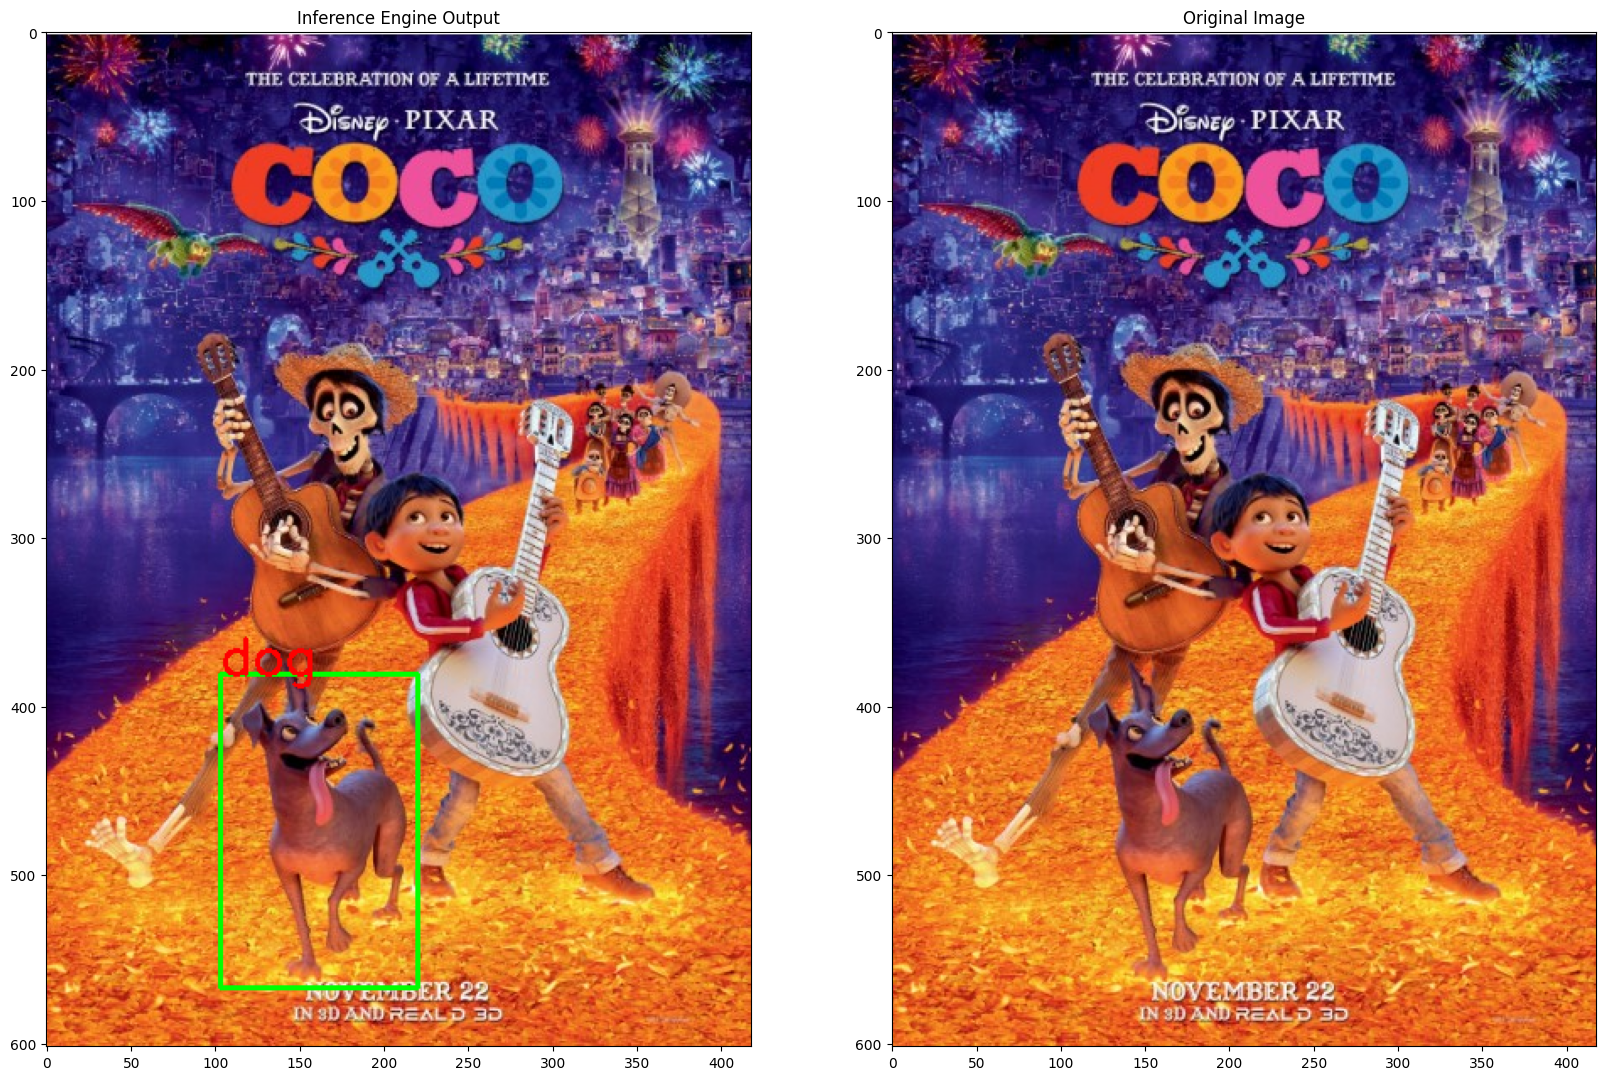

In [25]:
inference_engine_ov(str(image_path),detections,id_to_display_name)